In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'comp411/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/comp411/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from comp411.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'comp411/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


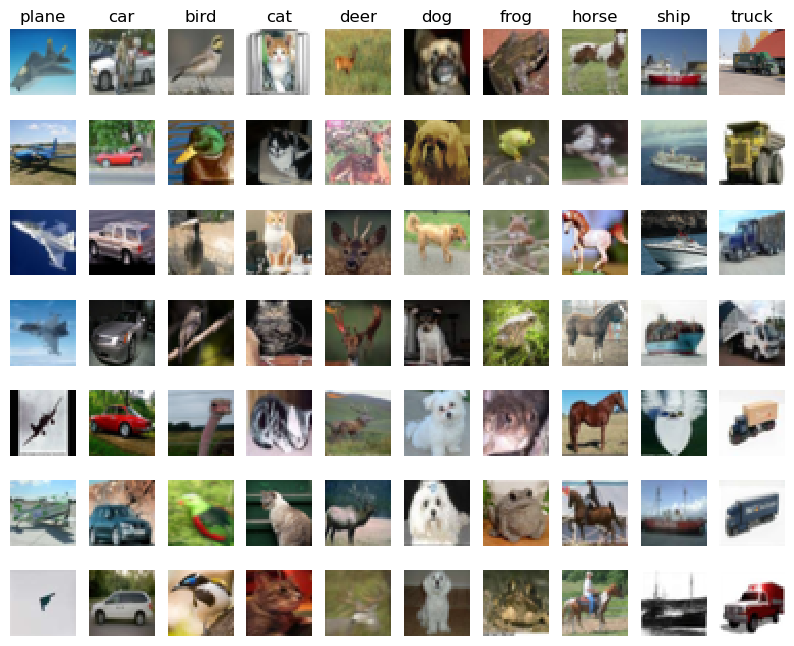

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


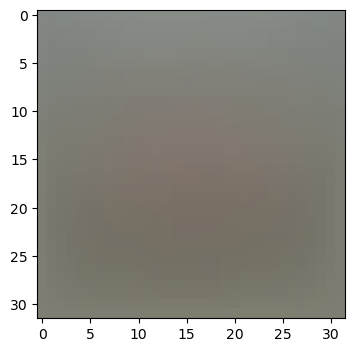

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `comp411/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [18]:
# Evaluate the naive implementation of the loss we provided for you:
from comp411.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.218244


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [16]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from comp411.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 6.360113 analytic: 6.360113, relative error: 6.952806e-12
numerical: -22.602637 analytic: -22.602637, relative error: 1.968540e-12
numerical: 2.818101 analytic: 2.818101, relative error: 2.307984e-12
numerical: 11.097185 analytic: 11.097185, relative error: 2.013491e-11
numerical: -18.864474 analytic: -18.864474, relative error: 1.812273e-11
numerical: -11.585697 analytic: -11.585697, relative error: 3.006692e-11
numerical: -4.649085 analytic: -4.649085, relative error: 7.960026e-11
numerical: -7.421714 analytic: -7.421714, relative error: 3.726586e-11
numerical: 8.436586 analytic: 8.436586, relative error: 1.291159e-11
numerical: 1.118488 analytic: 1.118488, relative error: 2.246686e-11
numerical: -11.138365 analytic: -11.138365, relative error: 2.831568e-11
numerical: 0.492370 analytic: 0.492370, relative error: 5.198172e-10
numerical: -22.264742 analytic: -22.264742, relative error: 1.120813e-11
numerical: -17.386672 analytic: -17.386672, relative error: 1.554564e-11
nume

## Modified Huber Classifier

Your code for this section will all be written inside `comp411/classifiers/linear_svm.py`. 

The Modified Huber Loss implementaiton should be similar to SVM Hinge Loss.

In [17]:
# Now implement and Evaluate the naive implementation of the huber loss:
from comp411.classifiers.linear_svm import huber_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = huber_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.117135


In [20]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = huber_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from comp411.gradient_check import grad_check_sparse
f = lambda w: huber_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = huber_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: huber_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -28.314491 analytic: -28.314491, relative error: 1.178634e-12
numerical: -11.691004 analytic: -11.691004, relative error: 3.260543e-11
numerical: -3.897723 analytic: -3.897723, relative error: 3.134179e-11
numerical: 0.507952 analytic: 0.507952, relative error: 3.772263e-10
numerical: 0.925539 analytic: 0.925539, relative error: 1.362781e-10
numerical: -31.317289 analytic: -31.317289, relative error: 3.561870e-12
numerical: 7.000208 analytic: 7.000208, relative error: 3.297575e-11
numerical: 1.853729 analytic: 1.853729, relative error: 1.396459e-10
numerical: -3.161875 analytic: -3.156200, relative error: 8.982233e-04
numerical: -0.309506 analytic: -0.309506, relative error: 1.100852e-09
numerical: 3.034507 analytic: 3.034507, relative error: 8.309066e-11
numerical: 7.028376 analytic: 7.028376, relative error: 3.214634e-11
numerical: -13.238174 analytic: -13.238174, relative error: 1.489715e-12
numerical: -0.258828 analytic: -0.258828, relative error: 1.070977e-09
numerical:

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *This discrepancy can be caused by the fact that the loss function is not differentiable near the kink of the function. As long as the discrepancies are small and not frequent, they will not cause a major difference in loss value. In the one dimensionional case our loss looks like Loss = max(0, s_j - s_i + 1), in this case our kink lies at x=1 and thus it's derivative at x=1 is undefined because grads on the left and right side are very different. If our numeric step takes us from 1 side of the x=1 to other side, there could be a difference between the analytical and the numerical computation of loss value. Larger margins may cause less occurences of this discrepancy hence margin size is inversly proportional to the probability of occurence of discrepancies.*  


In [22]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from comp411.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.218244e+00 computed in 0.094332s
Vectorized loss: 9.218244e+00 computed in 0.002089s
difference: 0.000000


In [33]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.109548s
Vectorized loss and gradient: computed in 0.002164s
difference: 0.000000


In [52]:
# Next implement the function huber_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = huber_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from comp411.classifiers.linear_svm import huber_loss_vectorized
tic = time.time()
loss_vectorized, _ = huber_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.218244e+00 computed in 0.091927s
Vectorized loss: 9.218244e+00 computed in 0.002234s
difference: 0.000000


In [56]:
# Complete the implementation of huber_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = huber_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = huber_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.114164s
Vectorized loss and gradient: computed in 0.001735s
difference: 0.000000


### Stochastic Gradient Descent with SVM

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `comp411/classifiers/linear_classifier.py`.

In [58]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from comp411.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()

loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 409.663328
iteration 100 / 1500: loss 241.252761
iteration 200 / 1500: loss 146.286702
iteration 300 / 1500: loss 90.601296
iteration 400 / 1500: loss 56.916981
iteration 500 / 1500: loss 36.465592
iteration 600 / 1500: loss 23.899279
iteration 700 / 1500: loss 16.016480
iteration 800 / 1500: loss 12.012089
iteration 900 / 1500: loss 8.902876
iteration 1000 / 1500: loss 7.376940
iteration 1100 / 1500: loss 6.077919
iteration 1200 / 1500: loss 6.055756
iteration 1300 / 1500: loss 5.221800
iteration 1400 / 1500: loss 5.505827
That took 2.295548s


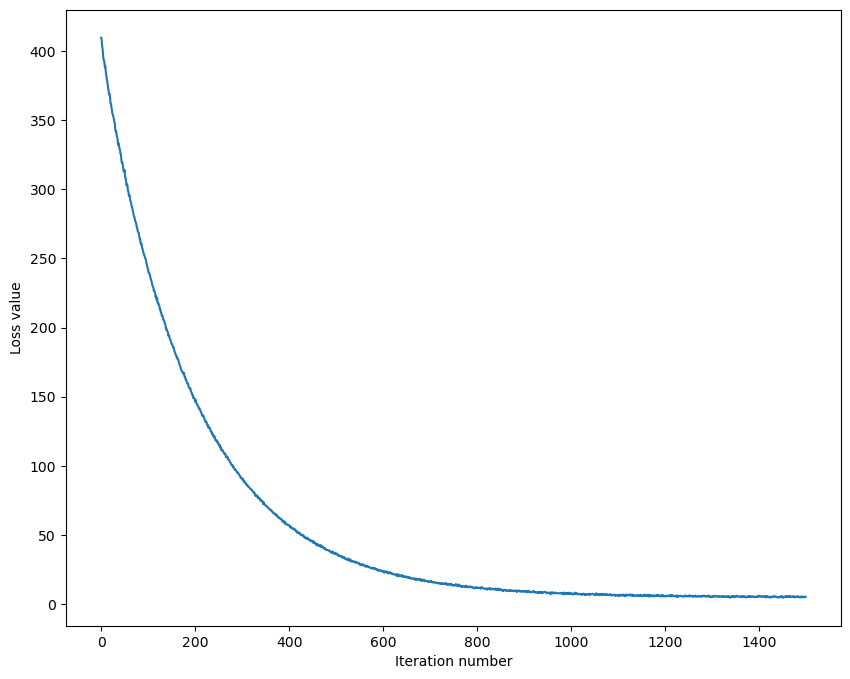

In [59]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [60]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.379000
validation accuracy: 0.392000


### Stochastic Gradient Descent with Huber
We also have vectorized and efficient expressions for the huber loss, the gradient and our gradient matches the numerical gradient. Thus, we are also ready to do SGD to minimize the huber loss.  Your code for this part will be written inside `comp411/classifiers/linear_classifier.py`.

In [61]:
from comp411.classifiers import LinearHuber
huber = LinearHuber()
tic = time.time()

loss_hist = huber.train(X_train, y_train, learning_rate=3e-7, reg=0,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 18.887293
iteration 100 / 1500: loss 8.811676
iteration 200 / 1500: loss 8.834752
iteration 300 / 1500: loss 6.814314
iteration 400 / 1500: loss 7.147342
iteration 500 / 1500: loss 6.079234
iteration 600 / 1500: loss 6.076036
iteration 700 / 1500: loss 5.735275
iteration 800 / 1500: loss 5.544498
iteration 900 / 1500: loss 5.270015
iteration 1000 / 1500: loss 6.333616
iteration 1100 / 1500: loss 6.341618
iteration 1200 / 1500: loss 5.341517
iteration 1300 / 1500: loss 6.372723
iteration 1400 / 1500: loss 6.446635
That took 2.289272s


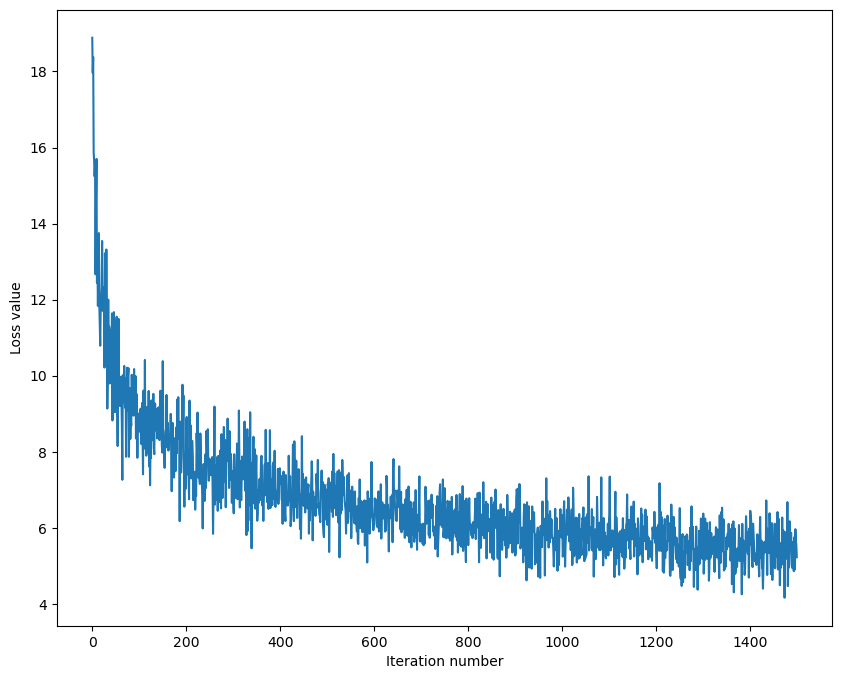

In [62]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [63]:
# Write the LinearHuber.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = huber.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = huber.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

## at minumim, you should see accuracy results around 0.25

training accuracy: 0.335408
validation accuracy: 0.334000


In [64]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate) and loss type (svm hinge or modified huber). You should experiment
# with different ranges for the learning rates and regularization strengths and cases
# for the loss type. If you are careful you should be able to
# get a classification accuracy of about 0.39 or higher on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug however you may want to add 
# safety margins for possible overflow/underflow causing operations in your .py implementations.

#Note: you may want to observe the behavioral differences between standard
#      svm hinge loss and modified huber loss

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength, loss_type) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best = None #  The LinearSVM or LinearHuber object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        
# Write code that chooses the best hyperparameters by tuning on the validation 
# set. For each combination of hyperparameters, train a linear SVM and a linear
# Huber on the training set, compute their accuracy on the training and 
# validation sets, and store these numbers in the results dictionary. In 
# addition, store the best validation accuracy in best_val and the LinearSVM 
# or LinearHuber object that achieves this, accuracy in best.    
#                                
#                                                                              
# Hint: You should use a small value for num_iters as you develop your         
# validation code so that the SVMs or Hubers don't take much time to train; once you are 
# confident that your validation code works, you should rerun the validation   
# code with a larger value for num_iters.                                      
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4, ]
loss_types = ["SVM", "Huber"]


# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        for lt in loss_types:
            if lt == "SVM":
                svm = LinearSVM()
                loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                            num_iters=1500, verbose=True)
                y_train_pred = svm.predict(X_train)
                y_val_pred = svm.predict(X_val)
                results[(lr, reg, lt)] = (np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred))
                if np.mean(y_val == y_val_pred) > best_val:
                    best_val = np.mean(y_val == y_val_pred)
                    best = svm
            else:
                huber = LinearHuber()
                loss_hist = huber.train(X_train, y_train, learning_rate=lr, reg=reg,
                            num_iters=1500, verbose=True)
                y_train_pred = huber.predict(X_train)
                y_val_pred = huber.predict(X_val)
                results[(lr, reg, lt)] = (np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred))
                if np.mean(y_val == y_val_pred) > best_val:
                    best_val = np.mean(y_val == y_val_pred)
                    best = huber

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg, lt in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, lt)]
    print('lr %e reg %e type %s train accuracy: %f val accuracy: %f' % (
                lr, reg, lt, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 408.035477
iteration 100 / 1500: loss 241.492979
iteration 200 / 1500: loss 145.613966
iteration 300 / 1500: loss 89.392759
iteration 400 / 1500: loss 56.519859
iteration 500 / 1500: loss 36.017541
iteration 600 / 1500: loss 23.299540
iteration 700 / 1500: loss 16.617523
iteration 800 / 1500: loss 12.032318
iteration 900 / 1500: loss 9.057343
iteration 1000 / 1500: loss 7.530818
iteration 1100 / 1500: loss 6.272341
iteration 1200 / 1500: loss 5.496410
iteration 1300 / 1500: loss 5.217677
iteration 1400 / 1500: loss 5.159137
iteration 0 / 1500: loss 785.339642
iteration 100 / 1500: loss 285.578728
iteration 200 / 1500: loss 107.210828
iteration 300 / 1500: loss 42.447149
iteration 400 / 1500: loss 18.910739
iteration 500 / 1500: loss 10.150189
iteration 600 / 1500: loss 7.451340
iteration 700 / 1500: loss 6.026362
iteration 800 / 1500: loss 5.982096
iteration 900 / 1500: loss 5.314702
iteration 1000 / 1500: loss 5.290880
iteration 1100 / 1500: loss 5.564762
iter

/Users/berademirhan/Desktop/Comp 411/comp411_assignment1_2023_questions/comp411/classifiers/linear_svm.py:199: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/Users/berademirhan/opt/anaconda3/envs/comp411/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/berademirhan/Desktop/Comp 411/comp411_assignment1_2023_questions/comp411/classifiers/linear_svm.py:199: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 788.375075
iteration 100 / 1500: loss 416737964193754199271880112121101418496.000000
iteration 200 / 1500: loss 68883447859721051889378269976424803783811189378210363893404847682663481344.000000
iteration 300 / 1500: loss 11385882249107613053771599933716521469392156786709508049750995278403293274862124578259512685905789615320596480.000000
iteration 400 / 1500: loss 1881995147144029855351961865940101770290096678030413421006364896770735903565981383713458736891145234409254926614557389273370718404007465727295488.000000
iteration 500 / 1500: loss 311078725072119953621403262302328186542302705724130219980417349138116834500798688977664718915531915521744988159199040941267218346741613388938671446378378597671005754424980035076096.000000
iteration 600 / 1500: loss 514188218494326259644595451229472045890815004651600831

/Users/berademirhan/Desktop/Comp 411/comp411_assignment1_2023_questions/comp411/classifiers/linear_svm.py:153: RuntimeWarning: overflow encountered in double_scalars
  loss += 1/2 * reg * np.sum(W * W)
/Users/berademirhan/Desktop/Comp 411/comp411_assignment1_2023_questions/comp411/classifiers/linear_svm.py:153: RuntimeWarning: overflow encountered in multiply
  loss += 1/2 * reg * np.sum(W * W)


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 1548.382088
iteration 100 / 1500: loss 4216860703828714845160066180133208455606719685968089396096948308281111671162476222089703734385009139089954390416955262631936.000000
iteration 200 / 1500: loss 10888988038371174458356590070304486914668322928630918777173699610719469294488626929005930768595184460370249718153617174126222590268432511431184913541996084610986654123555902664339110940497587507246941951785398679881584577474015484203504486055936.000000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf


/Users/berademirhan/Desktop/Comp 411/comp411_assignment1_2023_questions/comp411/classifiers/linear_svm.py:216: RuntimeWarning: overflow encountered in multiply
  dW +=  2 * reg * W
/Users/berademirhan/Desktop/Comp 411/comp411_assignment1_2023_questions/comp411/classifiers/linear_classifier.py:85: RuntimeWarning: invalid value encountered in subtract
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
lr 1.000000e-07 reg 2.500000e+04 type Huber train accuracy: 0.368000 val accuracy: 0.384000
lr 1.000000e-07 reg 2.500000e+04 type SVM train accuracy: 0.379184 val accuracy: 0.383000
lr 1.000000e-07 reg 5.000000e+04 type Huber train accuracy: 0.355531 val accuracy: 0.374000
lr 1.000000e-07 reg 5.000000e+04 type SVM train accuracy: 0.366939 val accuracy: 0.357000
lr 5.000000e-05 reg 2.500000e+04 type Huber train accuracy: 0.081571 val accuracy: 0.094000
lr 5.000000e-05 reg 2.500000e+04 type SVM train accuracy: 0.167898 val accuracy: 0.164000
lr 5.000000e-05 reg 5.000000e+04 type Huber train accuracy: 0.100265 val accuracy: 0.087000
lr 5.000000e-05 reg 5.000000e+04 type SVM train accuracy: 0.053653 val accurac

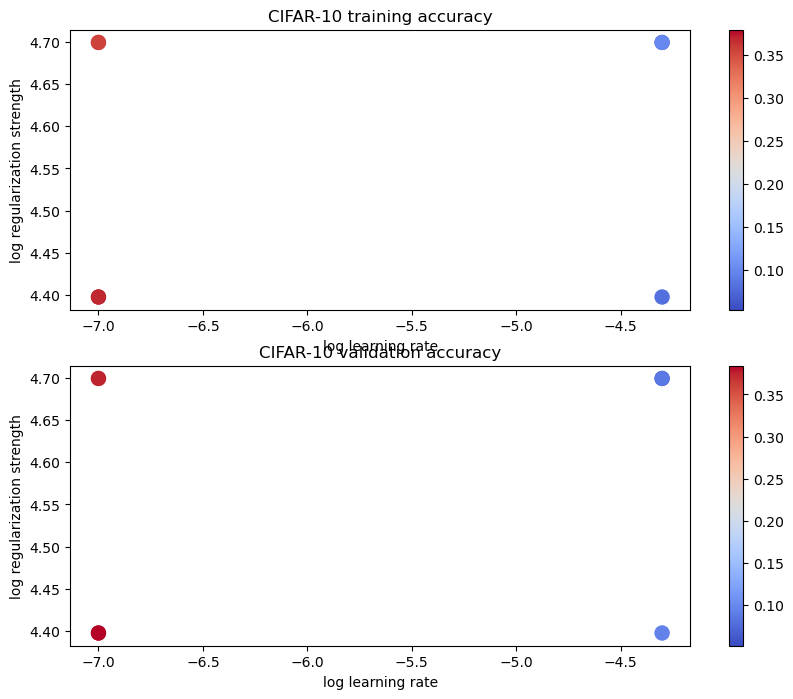

In [65]:
# Visualize the cross-validation results
import math

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [66]:
# Evaluate the best linear classifier on test set
y_test_pred = best.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear classifier on raw pixels final test set accuracy: %f' % test_accuracy)

linear classifier on raw pixels final test set accuracy: 0.360000


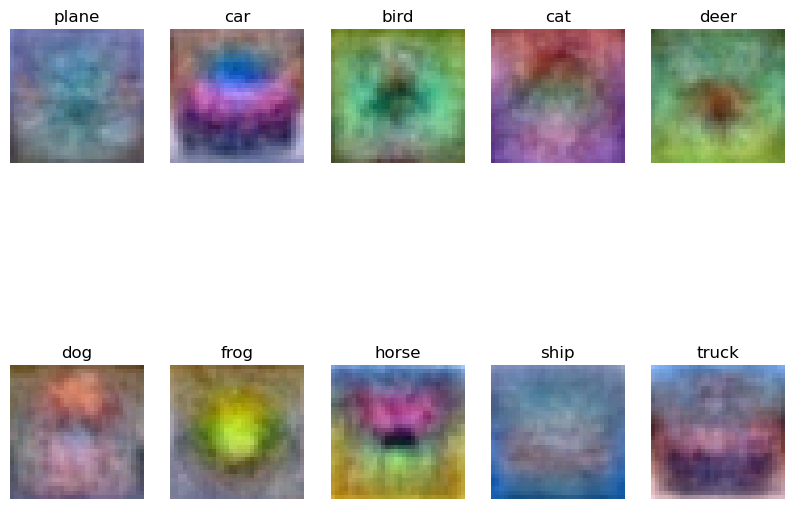

In [67]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized linear classifier weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *The trained weight matrices look like the images themselves, which is especially clear on the car, deer, dog, frog, horse, ship and truck classes in this case. The weights produce these images since we have set up the classifier to maximize the scores of the class the images belong to and the scores are higher when the weights look like the image themself, since there are overlaps of the pixels and this produces a higher score. In other words, the weight matrices look like a weighted average of the training images belonging to the corresponding class.*  
